# 0. Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.signal import correlate2d
from skimage import io, color, feature

# 1. Trick of Edge Detection
## 1-1. Smoothing using Gaussian Filter
 - Smoothing is to remove Noise from original Image so that we can prevent False Positive.
 - Tradeoff between smoothing and localization

Input Image


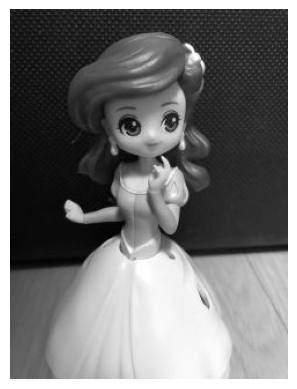

Smooth Image using Gaussian Filter


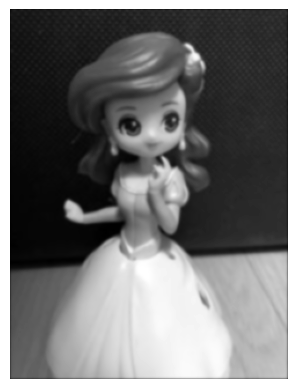

In [ ]:
###############################################
# Input Image
###############################################
RGBImage = io.imread('./drive/MyDrive/Computer Vision class/img/TheLittleMermaid1.JPG')
GrayImage = color.rgb2gray(RGBImage)

print('Input Image')
plt.axis('off')
plt.imshow(GrayImage, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

###############################################
# Smoothing using Gaussian Filter
###############################################
gaussian = np.array((
        [0.003,0.013,0.022,0.013,0.003],
        [0.013,0.059,0.097,0.059,0.013],
        [0.022,0.097,0.159,0.097,0.022],
        [0.013,0.059,0.097,0.059,0.013],
        [0.003,0.013,0.022,0.013,0.003]),
        dtype="float")

gaussianImage = convolve2d(GrayImage, gaussian, 'same')

print('Smooth Image using Gaussian Filter')
plt.axis('off')
plt.imshow(gaussianImage, cmap='gray')
plt.show()

## 1-2. Partial Derivatives of an image : ${I_x}, {I_y}$

$${I_x} = \frac{\partial f(x,y)}{\partial x} =  \lim_{ \epsilon \to 0} \frac{f(x+ \epsilon ,y) - f(x,y)}{ \epsilon }   
\approx \frac{f(x+ 1 ,y) - f(x,y)}{ 1 }$$
<br></br>
$${I_y} = \frac{\partial f(x,y)}{\partial y} =  \lim_{ \epsilon \to 0} \frac{f(x,y+\epsilon ) - f(x,y)}{ \epsilon }   
\approx \frac{f(x, y+1) - f(x,y)}{ 1 }$$

Ix Result Image


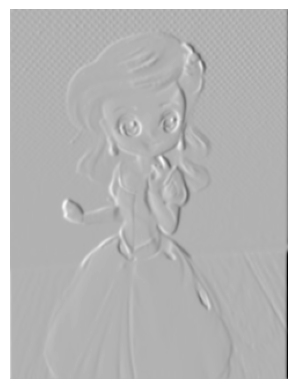

Iy Result Image


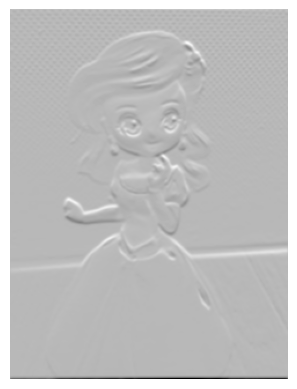

In [ ]:
###############################################
# x-axis partial derivative image (Ix)
# filter : [[-1, 1]]
###############################################
Ix_filter = np.array([[-1,1]], dtype="float")

Ix_image = correlate2d(gaussianImage, Ix_filter, 'same')

print('Ix Result Image')
plt.axis('off')
plt.imshow(Ix_image, cmap='gray')
plt.show()

###############################################
# y-axis partial derivative image (Iy)
# filter : [[-1],[1]]
###############################################
Iy_filter = np.array([[-1],[1]], dtype="float")

Iy_image = correlate2d(gaussianImage, Iy_filter, 'same')

print('Iy Result Image')
plt.axis('off')
plt.imshow(Iy_image, cmap='gray')
plt.show()

## 1-3. Gradient Magnitude Image : $\sqrt{I_x^2 + I_y^2}$
- The gradient magnitude edge is large along a thick lines :(



Gradient Magnitude Result Image


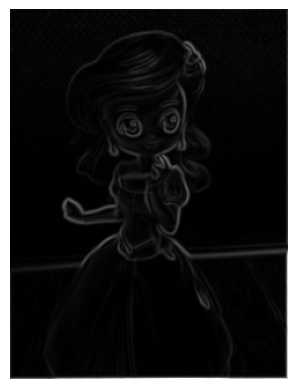

In [ ]:
###############################################
# Gradient Magnitude(Amplitude) Image
# sqrt(Ix^2 + Iy^2)
###############################################

gradient_magnitude_image = np.sqrt(Ix_image**2 + Iy_image**2)

print('Gradient Magnitude Result Image')
plt.axis('off')
plt.imshow(gradient_magnitude_image, cmap='gray')
plt.show()

# 2. Canny Edge Detector
J. Canny, A Computational Approach To Edge Detection, IEEE
Trans. Pattern Analysis and Machine Intelligence, 8:679-714, 1986.
## step1. Filter Image with x, y derivatives of Gaussian
- same as convolving Gaussian and then get derivatives


$$\frac{\partial (f \ast g)}{\partial x}  = f  \ast  \frac{\partial g}{\partial x}$$

Ix Result Image


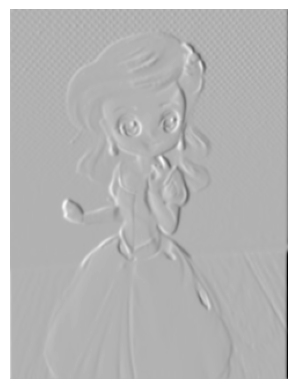

Iy Result Image


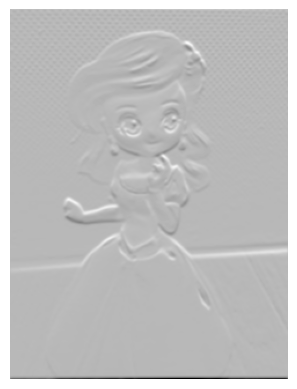

In [ ]:
print('Ix Result Image')
plt.axis('off')
plt.imshow(Ix_image, cmap='gray')
plt.show()

print('Iy Result Image')
plt.axis('off')
plt.imshow(Iy_image, cmap='gray')
plt.show()

## step2. Find Magnitude and Orientation of Gradient
- Orientation of Gradient is just an angle(theta)
$$\theta =  \tan^{-1}( \frac{\partial f}{\partial y}  /  \frac{\partial f}{\partial x} )$$

Gradient Magnitude Result Image


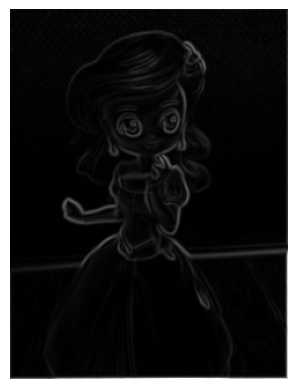

Gradient Orientation Result Image


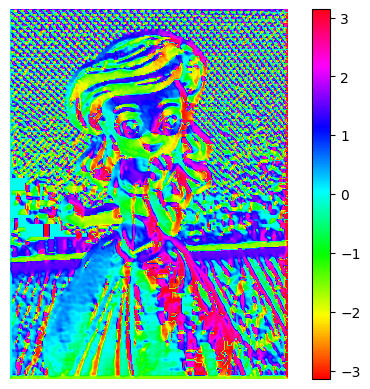

In [ ]:
print('Gradient Magnitude Result Image')
plt.axis('off')
plt.imshow(gradient_magnitude_image, cmap='gray')
plt.show()

###############################################
# Gradient Orientation
# theta = arctan(fy / fx)
###############################################

orient_Image = np.arctan2(Iy_image, Ix_image)
print('Gradient Orientation Result Image')
plt.axis('off')
plt.imshow(orient_Image, cmap='hsv')
plt.colorbar()
plt.show()

## step3. Non-Maximum Suppression

<img src="https://drive.google.com/uc?id=1hr7hOoO_9936lPX6o5GkiRCHFKl6OrLt" width=400 height=200>

Non-Maximum Suppression Result Image


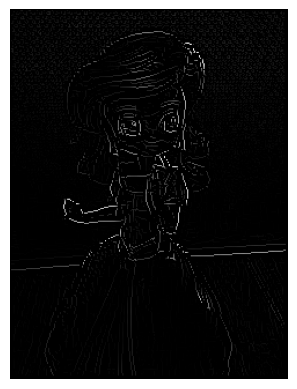

In [ ]:
###############################################
# Non-maximum Suppression
###############################################

orient_Image = orient_Image * (180 / np.pi) # radian -> degree
orient_Image[orient_Image < 0] += 180

# use (3 * 3) kernel
nms_Image = np.zeros(orient_Image.shape)
for i in range(orient_Image.shape[0]-1):
  for j in range(orient_Image.shape[1]-1):
    right = 1
    left = 1
    # degree 0
    if (0 <= orient_Image[i,j] < 22.5) or (157.5 <= orient_Image[i,j] <= 180):
      right = gradient_magnitude_image[i,j+1]
      left = gradient_magnitude_image[i,j-1]

    # degree 45
    elif 22.5 <= orient_Image[i,j] < 67.5:
      right = gradient_magnitude_image[i-1,j+1]
      left = gradient_magnitude_image[i+1,j-1]

    # degree 90
    elif 67.5 <= orient_Image[i,j] < 112.5:
      right = gradient_magnitude_image[i+1,j]
      left = gradient_magnitude_image[i-1,j]

    # degree 135
    elif 112.5 <= orient_Image[i,j] < 157.5:
      right = gradient_magnitude_image[i-1,j-1]
      left = gradient_magnitude_image[i+1,j+1]

    # non-Max Suppression
    if(max(gradient_magnitude_image[i,j], max(left, right))) == gradient_magnitude_image[i,j]:
      nms_Image[i,j] = gradient_magnitude_image[i,j]

print('Non-Maximum Suppression Result Image')
plt.axis('off')
plt.imshow(nms_Image, cmap='gray')
plt.show()

## step4. Hysteresis thresholding
- Two thresholds: high and low
- remove noise
1. pixel > high threshold, then it is strong edge
2. pixel < low threshold, then it is noise
3. pixel in between two threshold, then it is weak edge

Hysteresis Thresholding Result Image


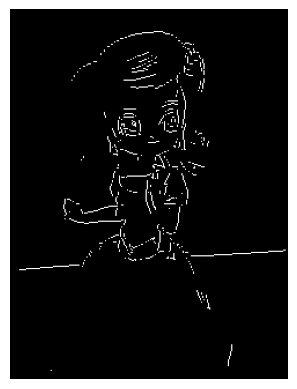

In [ ]:
###############################################
# Hysteresis Thresholding
###############################################

hys_Image = np.zeros(nms_Image.shape)
low_threshold_ratio = 0.05
high_threshold_ratio = 0.2

# Hysteresis thresholding
high_threshold = nms_Image.max() * high_threshold_ratio
low_threshold = nms_Image.max() * low_threshold_ratio

weak = np.int32(0.5) # weak edge
strong = np.int32(1) # strong edge

strong_i, strong_j = np.where(nms_Image > high_threshold)
noise_i, noise_j = np.where(nms_Image < low_threshold) # remove
weak_i, weak_j = np.where((nms_Image <= high_threshold) & (nms_Image >= low_threshold))

hys_Image[strong_i, strong_j] = strong
hys_Image[weak_i, weak_j] = weak
# hys_Image[noise_i, noise_i] = 0

print('Hysteresis Thresholding Result Image')
plt.axis('off')
plt.imshow(hys_Image, cmap='gray')
plt.show()

## Step5. Edge Linking
- Follow edges starting from strong edge pixels and continue them into weak edges

Canny Edge Detector Result Image


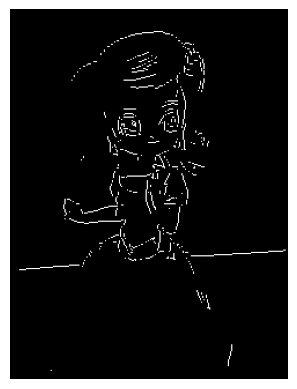

In [ ]:
###############################################
# Edge Tracking (Edge Linking)
# Then, it is Canny Edge Detector
###############################################

cannyImage = hys_Image.copy()

for i in range(hys_Image.shape[0]-1):
  for j in range(hys_Image.shape[1]-1):
    if (hys_Image[i, j] == weak):
      if ((hys_Image[i+1, j-1] == strong) or (hys_Image[i+1, j] == strong) or (hys_Image[i+1, j+1] == strong) or (hys_Image[i, j-1] == strong) or (hys_Image[i, j+1] == strong) or (hys_Image[i-1, j-1] == strong) or (hys_Image[i-1, j] == strong) or (hys_Image[i-1, j+1] == strong)):
        cannyImage[i, j] = weak
      else:
        cannyImage[i, j] = np.int32(0)


print('Canny Edge Detector Result Image')
plt.axis('off')
plt.imshow(cannyImage, cmap='gray')
plt.show()

# 3. skimage.feature.canny()

Canny Edge Detector with sigma = 0.1


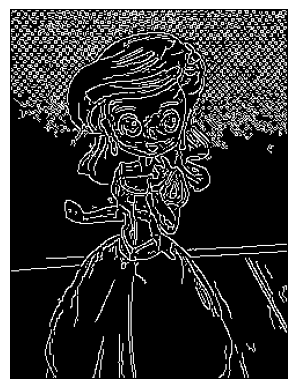

Canny Edge Detector with sigma = 1


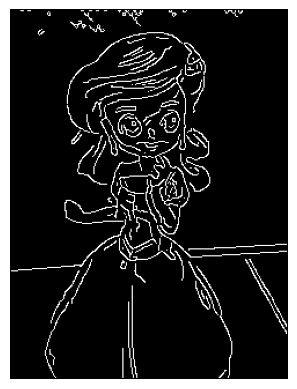

Canny Edge Detector with sigma = 3


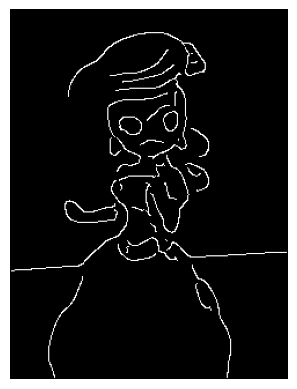

In [ ]:
edge1 = feature.canny(GrayImage, sigma=0.01)
edge2 = feature.canny(GrayImage, sigma=1)
edge3 = feature.canny(GrayImage, sigma=3)

print('Canny Edge Detector with sigma = 0.1')
plt.axis('off')
plt.imshow(edge1, cmap='gray')
plt.show()

print('Canny Edge Detector with sigma = 1')
plt.axis('off')
plt.imshow(edge2, cmap='gray')
plt.show()

print('Canny Edge Detector with sigma = 3')
plt.axis('off')
plt.imshow(edge3, cmap='gray')
plt.show()

Reference : https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123